In [56]:
import os
import numpy as np
import datetime
from tensorflow_core.python.keras.callbacks import EarlyStopping
from tensorflow_core.python.keras.utils import np_utils
from tensorflow_core.python.keras.models import Sequential
from tensorflow_core.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.python import math_ops
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow_core.python.keras.layers import Activation
from tensorflow_core.python.keras.utils import get_custom_objects   # 自定義gelu

np.random.seed(10)

In [57]:

sentence_type = 'SA1'
# sentence_type = 'SA2'
# sentence_type = 'SA'
sentence_type = 'SX'

Tr_ver = 'orig_50_DR25_M_'
Te_ver = 'orig_50_DR25_M_'
# --------------------------------------------------
Tr_ver = 'pe_50_DR25_M_'
Te_ver = 'pe_50_DR25_M_'

Tr_ver += sentence_type + '_'
Te_ver += sentence_type + '_'

# Tr_ver += '2_'
# Te_ver += '2_'

shape = 50

now_path = r'D:\TIMITDIC_231101'
data_path = now_path + '_data_CLIPS'

Tr_CDF_path = os.path.join(data_path, 'TRAIN', 'cnn_dataset_librosa')
Te_CDF_path = os.path.join(data_path, 'TEST', 'cnn_dataset_librosa')

Tr_DS_path = os.path.join(Tr_CDF_path, 'mfcc', Tr_ver + 'SoundDataset.npz')

Te_DS_path = os.path.join(Te_CDF_path, 'mfcc', Te_ver + 'SoundDataset.npz')

In [58]:
Tr_DS = np.load(Tr_DS_path)
Te_DS = np.load(Te_DS_path)

train_value, train_label = Tr_DS['TrainValue'], Tr_DS['TrainLabel_class']
test_value, test_label = Te_DS['TestValue'], Te_DS['TestLabel_class']
# test_value, test_label, test_label2 = Te_DS['TestValue'], Te_DS['TestLabel_class'], Te_DS['TestLabel_type']

train_value_4D = train_value.reshape(train_value.shape[0], shape, shape, 1).astype('float32')
test_value_4D = test_value.reshape(test_value.shape[0], shape, shape, 1).astype('float32')

# 向量轉換為二進制(只有0和1)的矩陣類型
# 但train_label、test_label原先資料就都是0跟1?
train_label_OneHot = np_utils.to_categorical(train_label)
test_label_OneHot = np_utils.to_categorical(test_label)

In [59]:
class Davis( Activation ):    
    def __init__(self, activation, **kwargs):
        super(Davis, self).__init__(activation, **kwargs)
        self.__name__ = 'custom_gelu'

def custom_gelu(x):
    return 0.5 * x * (1 + math_ops.tanh(math_ops.sqrt(2 / np.pi) * (x + 0.044715 * math_ops.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Davis(custom_gelu)})
get_custom_objects().update({'Davis': (Activation)})

In [60]:
activation_cate = 'relu'
# activation_cate = 'custom_gelu'
# activation_cate = 'sigmoid'
# activation_cate = 'elu'
# activation_cate = 'tanh'
kernel_size = 3

model = Sequential()
model.add(Conv2D(16, (kernel_size, kernel_size), input_shape=(shape, shape, 1), padding='same', activation=activation_cate))
model.add(Conv2D(16, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(16, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
# model.add(Conv2D(128, (3, 3), padding='same', activation='custom_gelu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='custom_gelu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation=activation_cate))
# model.add(Dropout(0.2))
model.add(Dense(128, activation=activation_cate))
model.add(Dropout(0.5))
# model.add(Dense(32, activation=activation_cate))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [61]:
model.summary()
model.compile(loss='binary_crossentropy',  # mean_squared_error, binary_crossentropy, categorical_crossentropy
              optimizer="adam",  # sgd, rmsprop, adam
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 50, 50, 16)        160       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 25, 25, 16)        2320      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)       

In [62]:
# 創建一個早停法的回調函數
# early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
# early_stopping = EarlyStopping(monitor='val_acc', patience=100, restore_best_weights=True)

train_history=model.fit(x=train_value_4D,
                        y=train_label_OneHot,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=10,
                        verbose=2,
                        # callbacks=[early_stopping])
                        )

Train on 280 samples, validate on 70 samples
Epoch 1/100
280/280 - 1s - loss: 0.5864 - acc: 0.7250 - val_loss: 0.4833 - val_acc: 0.8143
Epoch 2/100
280/280 - 0s - loss: 0.5365 - acc: 0.7429 - val_loss: 0.4107 - val_acc: 0.8143
Epoch 3/100
280/280 - 0s - loss: 0.4345 - acc: 0.7429 - val_loss: 0.2714 - val_acc: 0.8143
Epoch 4/100
280/280 - 0s - loss: 0.2879 - acc: 0.8393 - val_loss: 0.1400 - val_acc: 0.9857
Epoch 5/100
280/280 - 0s - loss: 0.1439 - acc: 0.9714 - val_loss: 0.0216 - val_acc: 1.0000
Epoch 6/100
280/280 - 0s - loss: 0.0318 - acc: 0.9964 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 7/100
280/280 - 0s - loss: 0.0804 - acc: 0.9643 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 8/100
280/280 - 0s - loss: 0.0430 - acc: 0.9786 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 9/100
280/280 - 0s - loss: 0.0286 - acc: 0.9929 - val_loss: 0.0101 - val_acc: 1.0000
Epoch 10/100
280/280 - 0s - loss: 0.0118 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 11/100
280/280 - 0s - loss: 0.0039 - a

{'loss': [0.5863924420305661, 0.5365116356738976, 0.43451316335371565, 0.28786040170650395, 0.14390222688338586, 0.03176843661016652, 0.08040377119245688, 0.043000030040275306, 0.02862951495215376, 0.011779493657806077, 0.003943232090026275, 0.0045724711916201545, 0.002194619281892431, 0.0011351313185227038, 0.0013399737801234682, 0.0023514031316454543, 0.00023948630266496757, 0.001828794297870116, 0.0011165936519341407, 0.002995986399293279, 0.0006494845258292312, 0.003361219201361137, 0.015104242576743079, 0.005606575222450212, 0.001056960116855965, 0.00033190392233959997, 0.10306371100951546, 0.04242267130127532, 0.010883489077944628, 0.005055473274556529, 0.002161475130604527, 0.0029654957518265063, 0.0008112135658661249, 0.001546924478863573, 0.0006464549727079486, 0.00013161380589273217, 0.00043312733725172796, 0.0007494266340765268, 0.0005536020464261984, 0.0005553341180483276, 0.00024934213684746354, 0.00011645296168889223, 0.0022543089861871224, 0.00010286417179004661, 2.18547

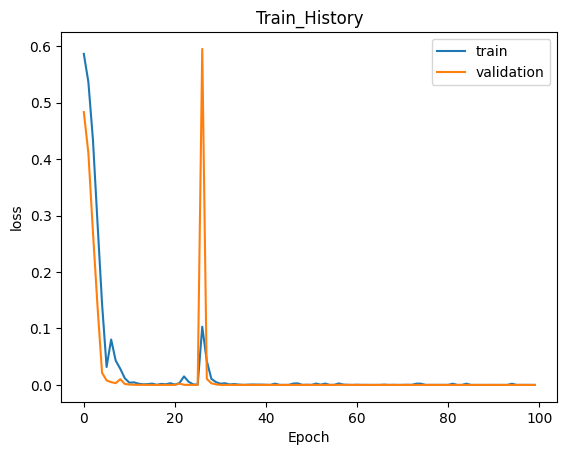

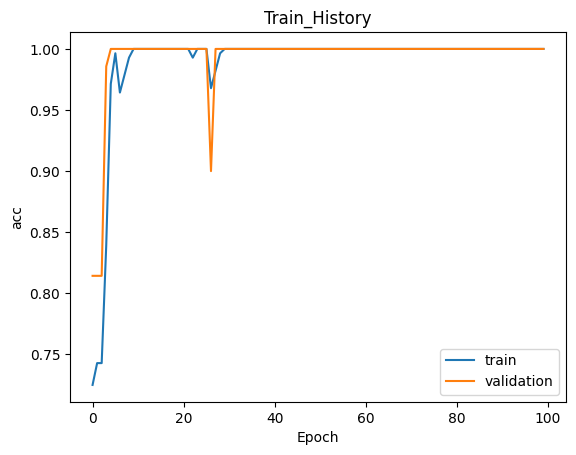

In [63]:
now_str = datetime.datetime.now()
now_str = datetime.datetime.strftime(now_str, '%Y%m%d_%H%M%S')

def show_train_history(train_history, train, validation):
    # 定義show_train_history函數，輸入下列參數:之前訓練過程所產生的train_history、
    # ...訓練資料的執行結果、驗證資料的執行結果
    print(train_history.history)
    plt.style.use('default')
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train_History')  # 顯示圖的標題
    plt.ylabel(train)  # 顯示y軸的標籤
    plt.xlabel('Epoch')  # 設定x軸標籤是'Epoch'
    plt.legend(['train', 'validation'], loc='best')
    # 設定國例是顯示'train', 'validation',位置在左上角

    train_history_path = os.path.join(now_path, 'train_history', Tr_ver)
    os.makedirs(train_history_path, exist_ok=True)

    plt.savefig(os.path.join(train_history_path, now_str + '_' + train + '.png'), bbox_inches='tight', pad_inches=0)

    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'acc', 'val_acc')
# show_train_history(train_history, 'accuracy', 'val_accuracy')

In [64]:
scores = model.evaluate(test_value_4D, test_label_OneHot)
print('loss=', scores[0], '\nacc=', scores[1])

f = open(os.path.join(now_path, 'train_history', 'train_history.txt'), 'a+')  # a+

content = f.read()
f.seek(0, 0)

f.write('\n' + '---------------------------------' + '\n')
f.write('\n' + '*****' + Tr_ver + '*****' + '\n')
f.write(now_str + '\n')
f.write('loss=' + '\n' + str(scores[0]) + '\n')
f.write('acc=' + '\n' + str(scores[1]))

f.write('\n' + content)
f.close()

110/110 [==============================] - 0s 2ms/sample - loss: 0.0041 - acc: 1.0000
loss= 0.004139031605287032 
acc= 1.0


In [65]:
# 使用pd.crosstab建立混淆矩陣，輸入下列參數:
prediction = model.predict_classes(test_value_4D)
pd.crosstab(test_label,  # 測試資料數字影像的其實值
            prediction,  # 測試資料數字影像的預測結果
            rownames=['label'],  # 設定行的名稱是label
            colnames=['predict'])  # 設定列的名稱是predict

predict,0,1
label,,
0,90,0
1,0,20


In [66]:
MWpath = os.path.join(now_path, '..\..', 'model_weight')
os.makedirs(MWpath, exist_ok=True)
Wver = now_path.split('\\')[-1]
model.save(os.path.join(MWpath, Tr_ver + 'SoundWeight_' + Wver + '_type2.h5'))